In [1]:
import torch.nn as nn
import torch
import os
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from DogsCatsDataloader import DogsCatsDataset
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from GaborLayers import GaborConv2d

In [2]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256,256)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train_set = DogsCatsDataset(root_dir='D:\\Dogs vs Cats\\train', transform=transform)
test_set = DogsCatsDataset(root_dir='D:\\Dogs vs Cats\\validation', transform=transform)

In [4]:
train = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
test = DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4)

In [5]:
len(train)

283

In [6]:
one_layer_gnet_acc_train = []
one_layer_gnet_loss_train = []
one_layer_gnet_acc_test = []
one_layer_gnet_loss_test = []

two_layer_gnet_acc_train = []
two_layer_gnet_loss_train = []
two_layer_gnet_acc_test = []
two_layer_gnet_loss_test = []

convnet_acc_train = []
convnet_loss_train = []
convnet_acc_test = []
convnet_loss_test = []

one_layer_cgnet_acc_train = []
one_layer_cgnet_loss_train = []
one_layer_cgnet_acc_test = []
one_layer_cgnet_loss_test = []

two_layer_cgnet_acc_train = []
two_layer_cgnet_loss_train = []
two_layer_cgnet_acc_test = []
two_layer_cgnet_loss_test = []

In [7]:
class GaborNet_one_layer(nn.Module):
    def __init__(self):
        super(GaborNet_one_layer, self).__init__()
        self.g1 = GaborConv2d(3, 32, kernel_size=(15,15), stride=1)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1)
        self.c3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.c4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(128*5*5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.g1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = x.view(-1, 128*5*5)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout()(x)
        x = self.fc3(x)
        return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = GaborNet_one_layer().to(device)
net.apply(weights_init)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

cuda:0
GaborNet_one_layer(
  (g1): GaborConv2d(3, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [9]:
for epoch in range(100):

    running_loss = 0.0
    correct = 0
    net.train()
    for i, data in enumerate(train, 0):
        # get the inputs
        inputs, labels = data['image'], data['target']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to('cpu')
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # print statistics
        running_loss += loss.item()
    print('[%d] train_acc: %.3f train_loss: %.3f' %(epoch + 1, correct/len(train_set), running_loss/len(train_set))) 
    one_layer_gnet_acc_train.append(correct/len(train_set))
    one_layer_gnet_loss_train.append(running_loss/len(train_set)) 
    
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test, 0):
            # get the inputs
            inputs, labels = data['image'], data['target']

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            pred = outputs.max(1, keepdim=True)[1].to('cpu')
            correct += pred.eq(labels.view_as(pred)).sum().item()
            running_loss += loss.item()
    print('[%d] test_acc: %.3f test_loss: %.3f' %(epoch + 1, correct/len(test_set), running_loss/len(test_set)))
    one_layer_gnet_acc_test.append(correct/len(test_set))
    one_layer_gnet_loss_test.append(running_loss/len(test_set))      

print('Finished Training')

np.save('DC_new_init_one_layer_gnet_acc_train_20_03.npy', one_layer_gnet_acc_train)
np.save('DC_new_init_one_layer_gnet_loss_train_20_03.npy', one_layer_gnet_loss_train)
np.save('DC_new_init_one_layer_gnet_acc_test_20_03.npy', one_layer_gnet_acc_test)
np.save('DC_new_init_one_layer_gnet_loss_test_20_03.npy', one_layer_gnet_loss_test)

[1] train_acc: 0.503 train_loss: 0.011
[1] test_acc: 0.517 test_loss: 0.011
[2] train_acc: 0.543 train_loss: 0.011
[2] test_acc: 0.579 test_loss: 0.011
[3] train_acc: 0.597 train_loss: 0.011
[3] test_acc: 0.620 test_loss: 0.010
[4] train_acc: 0.634 train_loss: 0.010
[4] test_acc: 0.643 test_loss: 0.010
[5] train_acc: 0.654 train_loss: 0.010
[5] test_acc: 0.661 test_loss: 0.010
[6] train_acc: 0.660 train_loss: 0.010
[6] test_acc: 0.669 test_loss: 0.010
[7] train_acc: 0.668 train_loss: 0.010
[7] test_acc: 0.673 test_loss: 0.010
[8] train_acc: 0.676 train_loss: 0.010
[8] test_acc: 0.676 test_loss: 0.010
[9] train_acc: 0.683 train_loss: 0.010
[9] test_acc: 0.685 test_loss: 0.009
[10] train_acc: 0.682 train_loss: 0.009
[10] test_acc: 0.679 test_loss: 0.010
[11] train_acc: 0.690 train_loss: 0.009
[11] test_acc: 0.687 test_loss: 0.009
[12] train_acc: 0.688 train_loss: 0.009
[12] test_acc: 0.693 test_loss: 0.009
[13] train_acc: 0.696 train_loss: 0.009
[13] test_acc: 0.685 test_loss: 0.009
[14]

In [13]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.c0 = nn.Conv2d(3, 32, kernel_size=(5,5), stride=1)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(5,5), stride=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1)
        self.c3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.c4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(128*5*5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c0(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = x.view(-1, 128*5*5)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout()(x)
        x = self.fc3(x)
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = convNet().to(device)
#net.apply(weights_init)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

cuda:0
convNet(
  (c0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (c1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (c3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (c4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


In [15]:
for epoch in range(100):

    running_loss = 0.0
    correct = 0
    net.train()
    for i, data in enumerate(train, 0):
        # get the inputs
        inputs, labels = data['image'], data['target']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        pred = outputs.max(1, keepdim=True)[1].to('cpu')
        correct += pred.eq(labels.view_as(pred)).sum().item()

        # print statistics
        running_loss += loss.item()
    print('[%d] train_acc: %.3f train_loss: %.3f' %(epoch + 1, correct/len(train_set), running_loss/len(train_set))) 
    convnet_acc_train.append(correct/len(train_set))
    convnet_loss_train.append(running_loss/len(train_set)) 
    
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test, 0):
            # get the inputs
            inputs, labels = data['image'], data['target']

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            pred = outputs.max(1, keepdim=True)[1].to('cpu')
            correct += pred.eq(labels.view_as(pred)).sum().item()
            running_loss += loss.item()
    print('[%d] test_acc: %.3f test_loss: %.3f' %(epoch + 1, correct/len(test_set), running_loss/len(test_set)))
    convnet_acc_test.append(correct/len(test_set))
    convnet_loss_test.append(running_loss/len(test_set))      

print('Finished Training')

np.save('convnet_acc_train_20_03.npy', convnet_acc_train)
np.save('convnet_loss_train_20_03.npy', convnet_loss_train)
np.save('convnet_acc_test_20_03.npy', convnet_acc_test)
np.save('convnet_loss_test_20_03.npy', convnet_loss_test)

[1] train_acc: 0.506 train_loss: 0.011
[1] test_acc: 0.503 test_loss: 0.011
[2] train_acc: 0.511 train_loss: 0.011
[2] test_acc: 0.498 test_loss: 0.011
[3] train_acc: 0.520 train_loss: 0.011
[3] test_acc: 0.515 test_loss: 0.011
[4] train_acc: 0.539 train_loss: 0.011
[4] test_acc: 0.515 test_loss: 0.011
[5] train_acc: 0.544 train_loss: 0.011
[5] test_acc: 0.555 test_loss: 0.011
[6] train_acc: 0.564 train_loss: 0.011
[6] test_acc: 0.578 test_loss: 0.011
[7] train_acc: 0.573 train_loss: 0.011
[7] test_acc: 0.589 test_loss: 0.011
[8] train_acc: 0.598 train_loss: 0.010
[8] test_acc: 0.598 test_loss: 0.011
[9] train_acc: 0.599 train_loss: 0.010
[9] test_acc: 0.613 test_loss: 0.010
[10] train_acc: 0.613 train_loss: 0.010
[10] test_acc: 0.616 test_loss: 0.010
[11] train_acc: 0.618 train_loss: 0.010
[11] test_acc: 0.609 test_loss: 0.010
[12] train_acc: 0.619 train_loss: 0.010
[12] test_acc: 0.614 test_loss: 0.010
[13] train_acc: 0.616 train_loss: 0.010
[13] test_acc: 0.606 test_loss: 0.010
[14]

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
convnet_acc_train = np.load('convnet_acc_train_20_03.npy')
convnet_acc_test = np.load('convnet_acc_test_20_03.npy')

one_layer_gnet_acc_test = np.load('DC_new_init_one_layer_gnet_acc_train_20_03.npy')
one_layer_gnet_acc_train = np.load('DC_new_init_one_layer_gnet_acc_test_20_03.npy')

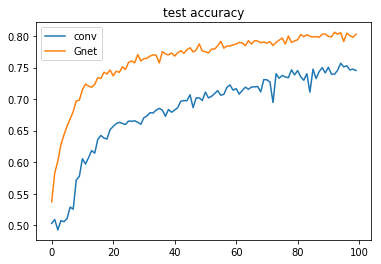

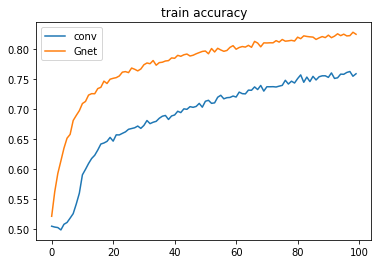

In [13]:
plt.plot(convnet_acc_test, label = 'Convolutional')
plt.plot(one_layer_gnet_acc_test, label = 'Gabor CNN')
plt.legend(loc = 0)
plt.grid()
plt.title('Test on Dogs vs Cats')
plt.show()
plt.plot(convnet_acc_train, label = 'Convolutional')
plt.plot(one_layer_gnet_acc_train, label = 'Gabor CNN')
plt.legend(loc = 0)
plt.title('Train on Dogs vs Cats')
plt.grid()
plt.show()

In [ ]:
class GaborNet_two_layer(nn.Module):
    def __init__(self):
        super(GaborNet_two_layer, self).__init__()
        self.g1 = GaborConv2d(3, 32, kernel_size=(15,15), stride=1)
        self.g2 = GaborConv2d(32, 64, kernel_size=(15,15), stride=1)
        self.c2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=1)
        self.c3 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.c4 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128,2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.g1(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.g2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c3(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        x = F.max_pool2d(F.relu(self.c4(x)), kernel_size=2)
        x = nn.Dropout2d()(x)
        print(x.shape)
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = F.relu(self.fc2(x))
        x = nn.Dropout()(x)
        x = self.fc3(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = GaborNet_two_layer().to(device)
net.apply(weights_init)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
net(torch.normal(torch.Tensor(1,3,256,256)).to(device))